In [2]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import ShapleyIndices, ShapleyKrigingIndices, SobolIndices, SobolKrigingIndices
from shapley.tests import Ishigami, AdditiveGaussian
from shapley.tests.utils import true_gaussian_full_ind_sobol
from shapley.plots import set_style_paper, plot_sensitivity_results
from shapley.plots import plot_correlation_indices

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = False
ylim = [-0.05, 1.05]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
dim = 3
beta = None
model = AdditiveGaussian(dim=dim, beta=beta)
model.margins = [ot.Normal()]*(dim-1) + [ot.Normal(0, 2.)]

(array([ 0.10004002,  0.89916006,  0.89976   ]),
 array([ 0.10004002,  0.00019998,  0.00079992]),
 array([ 0.10004002,  0.44968002,  0.45027996]))

In [97]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
n_corr = 30
corrs = np.linspace(-0.999, 0.999, n_corr)

Nv = 10000
No = 300
Ni = No

max_budget = Nv + No*Ni
print('Max budget:', max_budget)

estimator_sobol_full_ind = 'sobolmara'
n_boot = 1000

Max budget: 100000


In [98]:
result_indices = {'Shapley': [],
                  'First Sobol': [],
                  'Total Sobol': [],
                  'First full Sobol': [],
                  'Total full Sobol': [],
                  'First ind Sobol': [],
                  'Total ind Sobol': []
                 }

true_result_indices = {'Shapley': [],
                  'First Sobol': [],
                  'Total Sobol': [],
                  'First full Sobol': [],
                  'Total full Sobol': [],
                  'First ind Sobol': [],
                  'Total ind Sobol': []
                 }

for corr in corrs:
    theta = [0., 0., corr]
    model.copula_parameters = theta
    true_full_indices, true_ind_indices = true_gaussian_full_ind_sobol(theta, dim=dim)
        
    #Sobol Full and Ind
    n_sample = int(max_budget / (dim*4))
    sobol = SobolIndices(model.input_distribution)
    sobol.build_uncorrelated_mc_sample(model, n_sample)
    sobol_results_full = sobol.compute_full_indices(n_boot=n_boot, estimator=estimator_sobol_full_ind)
    sobol_results_ind = sobol.compute_ind_indices(n_boot=n_boot, estimator=estimator_sobol_full_ind)
    
    # Shapley
    shapley = ShapleyIndices(model.input_distribution)
    shapley.build_mc_sample(model=model, n_perms=None, Nv=Nv, No=No, Ni=Ni)
    shapley_results = shapley.compute_indices(n_boot=n_boot)
    
    # Save results
    result_indices['Shapley'].append(shapley_results.full_shapley_indices.ravel())
    result_indices['First Sobol'].append(shapley_results.full_first_indices.ravel())
    result_indices['Total Sobol'].append(shapley_results.full_total_indices.ravel())
    result_indices['First full Sobol'].append(sobol_results_full.full_first_indices.ravel())
    result_indices['Total full Sobol'].append(sobol_results_full.full_total_indices.ravel())    
    result_indices['First ind Sobol'].append(sobol_results_ind.full_first_indices.ravel())
    result_indices['Total ind Sobol'].append(sobol_results_ind.full_total_indices.ravel())
    
    # Save true results
    true_result_indices['Shapley'].append(model.shapley_indices)
    true_result_indices['First Sobol'].append(model.first_order_sobol_indices)
    true_result_indices['Total Sobol'].append(model.total_sobol_indices)

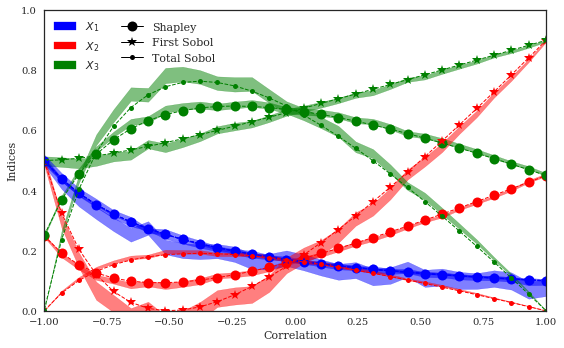

In [91]:
fig, ax=plt.subplots(figsize=(8, 5))

to_plot = ['Shapley', 'First Sobol', 'Total Sobol']

plot_correlation_indices(result_indices, corrs, n_boot, true_indices=true_result_indices, ax=ax, to_plot=to_plot, alpha=[0.025, 0.975], ci='error')
fig.tight_layout()
fig.savefig('./output/correlation_gaussian_dim_%d_Nv_%d_No_%d_Ni_%d.pdf' % (dim, Nv, No, Ni))

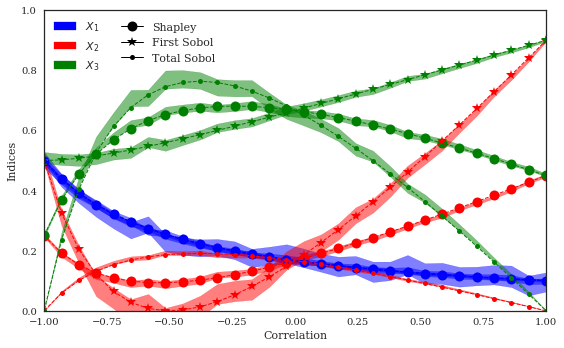

In [92]:
fig, ax=plt.subplots(figsize=(8, 5))

to_plot = ['Shapley', 'First Sobol', 'Total Sobol']

plot_correlation_indices(result_indices, corrs, n_boot, true_indices=true_result_indices, ax=ax, to_plot=to_plot, alpha=[0.01, 0.99], ci='quantile')
fig.tight_layout()

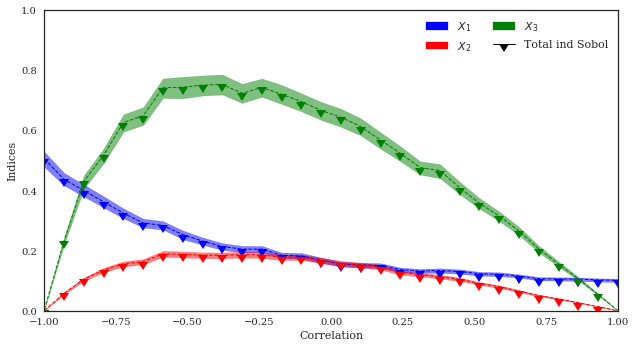

In [93]:
fig, ax = plt.subplots(figsize=(9, 5))

to_plot = ['Total ind Sobol']
plot_correlation_indices(result_indices, corrs, n_boot, ax=ax, to_plot=to_plot, alpha=[0.025, 0.975], ci='error')
fig.tight_layout()

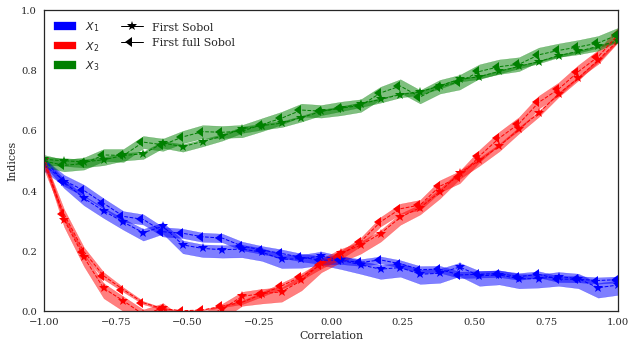

In [94]:
fig, ax = plt.subplots(figsize=(9, 5))
to_plot = ['First Sobol', 'First full Sobol']
plot_correlation_indices(result_indices, corrs, n_boot, ax=ax, to_plot=to_plot)
fig.tight_layout()

In [86]:
result_indices = {'Shapley': [],
                  'First Sobol': [],
                  'Total Sobol': [],
                  'First full Sobol': [],
                  'Total full Sobol': [],
                  'First ind Sobol': [],
                  'Total ind Sobol': []
                 }

shapley_kriging = SobolKrigingIndices(model.input_distribution)
shapley_kriging.
for corr in corrs:
    theta = [0., 0., corr]
    model.copula_parameters = theta
    true_full_indices, true_ind_indices = true_gaussian_full_ind_sobol(theta, dim=dim)
        
    #Sobol Full and Ind
    n_sample = int(max_budget / (dim*4))
    sobol = SobolIndices(model.input_distribution)
    sobol.build_uncorrelated_mc_sample(model, n_sample)
    sobol_results_full = sobol.compute_full_indices(n_boot=n_boot, estimator=estimator_sobol_full_ind)
    sobol_results_ind = sobol.compute_ind_indices(n_boot=n_boot, estimator=estimator_sobol_full_ind)
    
    # Shapley
    shapley = ShapleyIndices(model.input_distribution)
    shapley.build_mc_sample(model=model, n_perms=None, Nv=Nv, No=No, Ni=Ni)
    shapley_results = shapley.compute_indices(n_boot=n_boot)
    
    # Save results
    result_indices['Shapley'].append(shapley_results.full_shapley_indices.ravel())
    result_indices['First Sobol'].append(shapley_results.full_first_indices.ravel())
    result_indices['Total Sobol'].append(shapley_results.full_total_indices.ravel())
    result_indices['First full Sobol'].append(sobol_results_full.full_first_indices.ravel())
    result_indices['Total full Sobol'].append(sobol_results_full.full_total_indices.ravel())    
    result_indices['First ind Sobol'].append(sobol_results_ind.full_first_indices.ravel())
    result_indices['Total ind Sobol'].append(sobol_results_ind.full_total_indices.ravel())

SyntaxError: invalid syntax (<ipython-input-86-095bbefd695a>, line 11)